In [1]:
import sys
sys.path.insert(0, '../core')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import affinity
from shapely.ops import unary_union
import kaggle_support as kgs

# Initialize tree globals
kgs.set_float32(True)

print(f"Tree max radius: {kgs.tree_max_radius:.4f}")
print(f"Tree area: {kgs.tree_area:.4f}")

local
Tree max radius: 0.5796
Tree area: 0.2457


## Minkowski Sum Computation

For non-convex polygons, we compute the Minkowski sum by:
1. Decomposing both polygons into convex pieces (already done in `convex_breakdown`)
2. Computing pairwise Minkowski sums of all convex pieces
3. Taking the union of all results

For convex polygons, the Minkowski sum is computed by merging the edges sorted by angle.

In [ ]:
from shapely.geometry import Polygon, MultiPoint
from shapely.ops import unary_union

def _polygon_vertices(poly: Polygon):
    """
    Return unique exterior vertices (without the duplicated closing point).
    """
    coords = list(poly.exterior.coords)
    if len(coords) >= 2 and coords[0] == coords[-1]:
        coords = coords[:-1]
    return coords

def minkowski_difference_convex(A: Polygon, B: Polygon) -> Polygon:
    """
    Compute C = A ⊕ (-B), i.e. the set of translations t such that
    A intersects (B translated by t) is non-empty.

    For convex polygons, C is convex and can be computed exactly as the convex hull
    of all pairwise sums of vertices of A and (-B).

    Notes:
    - This corresponds to "overlap" including boundary contact (intersection non-empty).
    - If A or B are not convex, set ensure_convex=False and/or convexify them yourself,
      but then this vertex-sum+convex-hull method is not generally correct for non-convex.
    """

    A_verts = _polygon_vertices(A)
    B_verts = _polygon_vertices(B)

    # Reflect B through the origin: -B
    Bneg_verts = [(-x, -y) for (x, y) in B_verts]

    # Minkowski sum of convex polygons: convex hull of pairwise vertex sums
    pts = [(ax + bx, ay + by) for (ax, ay) in A_verts for (bx, by) in Bneg_verts]
    return MultiPoint(pts).convex_hull

print("Minkowski sum functions defined.")

Minkowski sum functions defined.


## Compute Minkowski Sum for Trees

Given two trees with rotations θ₁ and θ₂, the Minkowski sum M(Tree₁, -Tree₂) gives us the "forbidden zone" for the center of Tree₂ relative to Tree₁. If Tree₂'s center is inside this zone, the trees overlap.

In [14]:
def get_rotated_tree_and_parts(theta: float):
    """
    Get the tree polygon and its convex decomposition at a given rotation.
    
    Parameters
    ----------
    theta : float
        Rotation angle in radians
        
    Returns
    -------
    tree : Polygon
        Rotated tree polygon
    convex_parts : list of Polygon
        Rotated convex decomposition
    """
    tree = affinity.rotate(kgs.center_tree, np.degrees(theta), origin=(0, 0))
    convex_parts = [affinity.rotate(p, np.degrees(theta), origin=(0, 0)) 
                    for p in kgs.convex_breakdown]
    return tree, convex_parts


def compute_separation_minkowski(theta1: float, theta2: float):
    """
    Compute the Minkowski sum for two trees at given rotations.
    
    Returns the "no-go zone" for Tree2's center relative to Tree1 at origin.
    
    Parameters
    ----------
    theta1 : float
        Rotation of tree 1 (at origin)
    theta2 : float  
        Rotation of tree 2 (being placed)
        
    Returns
    -------
    minkowski_sum : Polygon or MultiPolygon
        The forbidden zone - tree2's center cannot be inside this region
    """
    # Get rotated trees and their convex decompositions
    tree1, parts1 = get_rotated_tree_and_parts(theta1)
    tree2, parts2 = get_rotated_tree_and_parts(theta2)
    
    # Reflect tree2 through origin for Minkowski difference
    parts2_reflected = reflect_convex_parts(parts2)
    
    # Compute Minkowski sum
    msum = minkowski_sum_nonconvex(tree1, reflect_polygon(tree2), 
                                    parts1, parts2_reflected)
    
    return msum, tree1, tree2


# Test with theta1=0, theta2=0
theta1, theta2 = 0.0, 0.0
msum, tree1, tree2 = compute_separation_minkowski(theta1, theta2)

print(f"Tree 1 rotation: {np.degrees(theta1):.1f}°")
print(f"Tree 2 rotation: {np.degrees(theta2):.1f}°")
print(f"Minkowski sum area: {msum.area:.6f}")
print(f"Minkowski sum bounds: {msum.bounds}")

Tree 1 rotation: 0.0°
Tree 2 rotation: 0.0°
Minkowski sum area: 1.810456
Minkowski sum bounds: (-0.7000399999999967, -1.5000399999999967, 0.7000399999999967, 0.5)


Convex breakdown pieces:
  Part 0: 3 vertices, area=0.037509, is_valid=True
    Coords: [(1.4711643753145823e-18, 0.579610585590614), (0.12501999999999835, 0.27959058559061556), (-0.12501999999999835, 0.27959058559061556), (1.4711643753145823e-18, 0.579610585590614)]
  Part 1: 4 vertices, area=0.065635, is_valid=True
    Coords: [(0.06250999999999918, 0.27959058559061556), (0.20002999999999754, 0.02959058559061556), (-0.20002999999999754, 0.02959058559061556), (-0.06250999999999918, 0.27959058559061556), (0.06250999999999918, 0.27959058559061556)]
  Part 2: 4 vertices, area=0.112509, is_valid=True
    Coords: [(0.10001499999999877, 0.02959058559061556), (0.35001999999999833, -0.22040941440938444), (-0.35001999999999833, -0.22040941440938444), (-0.10001499999999877, 0.02959058559061556), (0.10001499999999877, 0.02959058559061556)]
  Part 3: 4 vertices, area=0.030004, is_valid=True
    Coords: [(0.07500999999999917, -0.22040941440938444), (0.07500999999999917, -0.42040941440938445), (-0.

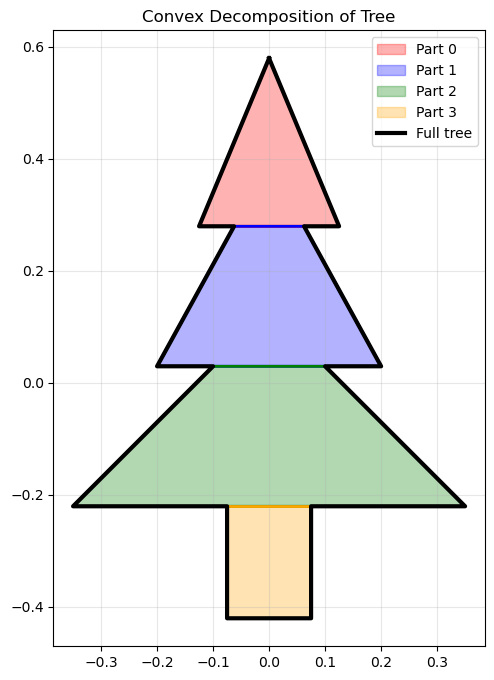


Full tree area: 0.245656
Union of parts area: 0.245656
Symmetric difference area: 0.000000


In [4]:
# Debug: check the convex breakdown
print("Convex breakdown pieces:")
for i, part in enumerate(kgs.convex_breakdown):
    print(f"  Part {i}: {len(part.exterior.coords)-1} vertices, area={part.area:.6f}, is_valid={part.is_valid}")
    coords = list(part.exterior.coords)
    print(f"    Coords: {coords}")

# Visualize the convex breakdown
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
colors = ['red', 'blue', 'green', 'orange']
for i, part in enumerate(kgs.convex_breakdown):
    x, y = part.exterior.xy
    ax.fill(x, y, alpha=0.3, color=colors[i], label=f'Part {i}')
    ax.plot(x, y, '-', color=colors[i], linewidth=2)

# Also plot the full tree
x, y = kgs.center_tree.exterior.xy
ax.plot(x, y, 'k-', linewidth=3, label='Full tree')

ax.legend()
ax.set_title('Convex Decomposition of Tree')
ax.grid(True, alpha=0.3)
plt.show()

# Check: does the union of convex parts equal the full tree?
from shapely.ops import unary_union
union_parts = unary_union(kgs.convex_breakdown)
print(f"\nFull tree area: {kgs.center_tree.area:.6f}")
print(f"Union of parts area: {union_parts.area:.6f}")
print(f"Symmetric difference area: {kgs.center_tree.symmetric_difference(union_parts).area:.6f}")

## Visualization

/tmp/ipykernel_18664/3226249382.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


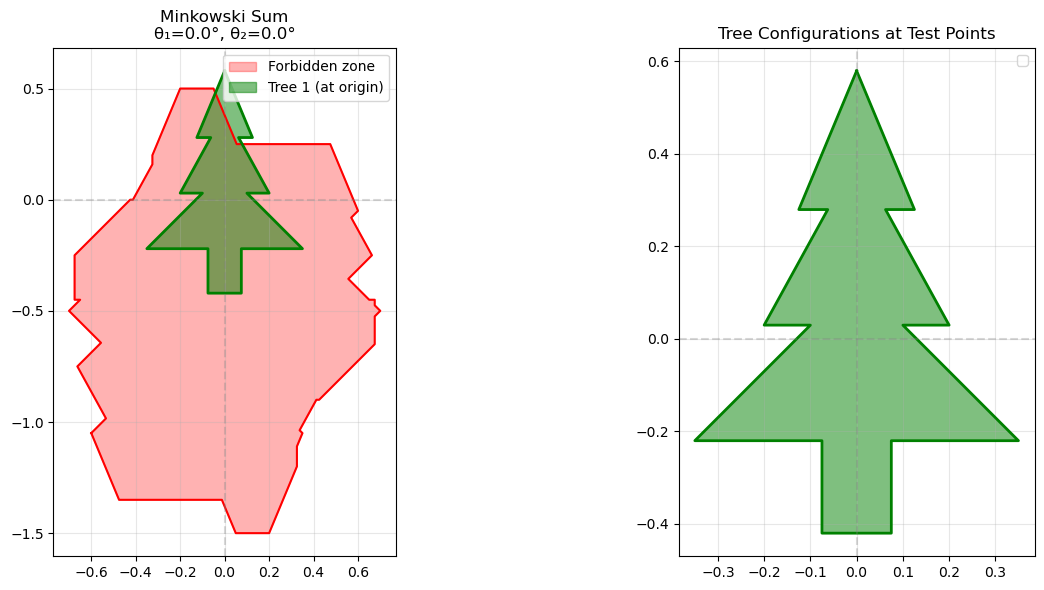

In [5]:
def plot_minkowski_and_trees(msum, tree1, tree2, theta1, theta2, test_points=None):
    """
    Visualize the Minkowski sum and test configurations.
    
    Parameters
    ----------
    msum : Polygon
        The Minkowski sum (forbidden zone)
    tree1, tree2 : Polygon
        The tree polygons at their rotations
    theta1, theta2 : float
        Rotation angles
    test_points : list of (x, y, label, color), optional
        Points to test and visualize
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left plot: Minkowski sum with test points
    ax = axes[0]
    ax.set_aspect('equal')
    ax.set_title(f'Minkowski Sum\nθ₁={np.degrees(theta1):.1f}°, θ₂={np.degrees(theta2):.1f}°')
    
    # Plot Minkowski sum
    if isinstance(msum, MultiPolygon):
        for geom in msum.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
            ax.plot(x, y, 'r-', linewidth=1.5)
    else:
        x, y = msum.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
        ax.plot(x, y, 'r-', linewidth=1.5)
    
    # Plot tree1 at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1 (at origin)')
    ax.plot(x, y, 'g-', linewidth=2)
    
    # Plot test points
    if test_points:
        for px, py, label, color in test_points:
            ax.plot(px, py, 'o', markersize=10, color=color, label=label)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Right plot: Actual tree configurations
    ax = axes[1]
    ax.set_aspect('equal')
    ax.set_title('Tree Configurations at Test Points')
    
    # Plot tree1 at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green')
    ax.plot(x, y, 'g-', linewidth=2)
    
    # Plot tree2 at each test point
    if test_points:
        for px, py, label, color in test_points:
            tree2_translated = affinity.translate(tree2, xoff=px, yoff=py)
            x, y = tree2_translated.exterior.xy
            ax.fill(x, y, alpha=0.3, color=color)
            ax.plot(x, y, '-', linewidth=2, color=color, label=label)
            ax.plot(px, py, 'o', markersize=8, color=color)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Basic visualization
fig = plot_minkowski_and_trees(msum, tree1, tree2, theta1, theta2)
plt.show()

## Accuracy Verification

We'll place trees at positions:
1. **Just inside** the Minkowski boundary (should overlap)
2. **Exactly on** the boundary (should just touch)
3. **Just outside** the boundary (should not overlap)

In [6]:
def find_boundary_point(msum, angle: float):
    """
    Find the point on the Minkowski sum boundary at a given angle from origin.
    
    Parameters
    ----------
    msum : Polygon
        The Minkowski sum
    angle : float
        Angle from origin in radians
        
    Returns
    -------
    (x, y) : tuple
        Point on boundary, or None if not found
    """
    from shapely.geometry import LineString
    
    # Create a ray from origin
    ray_length = 3.0  # Should be longer than max distance
    ray_end = (ray_length * np.cos(angle), ray_length * np.sin(angle))
    ray = LineString([(0, 0), ray_end])
    
    # Find intersection with boundary
    if isinstance(msum, MultiPolygon):
        boundary = unary_union([g.exterior for g in msum.geoms])
    else:
        boundary = msum.exterior
    
    intersection = ray.intersection(boundary)
    
    if intersection.is_empty:
        return None
    
    # Get the point (might be MultiPoint if ray crosses multiple times)
    if intersection.geom_type == 'Point':
        return (intersection.x, intersection.y)
    elif intersection.geom_type == 'MultiPoint':
        # Take the closest point to origin
        points = list(intersection.geoms)
        closest = min(points, key=lambda p: p.distance(Point(0, 0)))
        return (closest.x, closest.y)
    else:
        # LineString intersection - take first point
        coords = list(intersection.coords)
        return coords[0]


def verify_accuracy(theta1: float, theta2: float, test_angles: list = None):
    """
    Verify Minkowski sum accuracy by testing points inside/outside boundary.
    """
    if test_angles is None:
        test_angles = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, np.pi]
    
    msum, tree1, tree2 = compute_separation_minkowski(theta1, theta2)
    
    epsilon = 1e-4  # Small offset for inside/outside tests
    
    results = []
    
    for angle in test_angles:
        boundary_pt = find_boundary_point(msum, angle)
        if boundary_pt is None:
            continue
            
        bx, by = boundary_pt
        dist = np.sqrt(bx**2 + by**2)
        
        # Unit vector in this direction
        ux, uy = bx/dist, by/dist
        
        # Points just inside, on, and just outside boundary
        inside_pt = (bx - epsilon*ux, by - epsilon*uy)
        on_pt = (bx, by)
        outside_pt = (bx + epsilon*ux, by + epsilon*uy)
        
        # Check actual overlaps using Shapely
        for pt, pt_type in [(inside_pt, 'inside'), (on_pt, 'on'), (outside_pt, 'outside')]:
            tree2_at_pt = affinity.translate(tree2, xoff=pt[0], yoff=pt[1])
            intersection = tree1.intersection(tree2_at_pt)
            overlap_area = intersection.area
            
            # Check if point is inside Minkowski sum
            pt_in_msum = msum.contains(Point(pt))
            
            results.append({
                'angle_deg': np.degrees(angle),
                'position': pt_type,
                'x': pt[0],
                'y': pt[1],
                'in_minkowski': pt_in_msum,
                'overlap_area': overlap_area,
                'overlaps': overlap_area > 1e-10
            })
    
    return results, msum, tree1, tree2


# Run verification
theta1, theta2 = 0.0, 0.0
results, msum, tree1, tree2 = verify_accuracy(theta1, theta2)

print(f"\nVerification Results (θ₁={np.degrees(theta1):.1f}°, θ₂={np.degrees(theta2):.1f}°):")
print("-" * 80)
print(f"{'Angle':>8} {'Position':>10} {'In Mink':>10} {'Overlaps':>10} {'Overlap Area':>15}")
print("-" * 80)
for r in results:
    status = '✓' if r['in_minkowski'] == r['overlaps'] else '✗'
    print(f"{r['angle_deg']:>8.1f} {r['position']:>10} {str(r['in_minkowski']):>10} {str(r['overlaps']):>10} {r['overlap_area']:>15.2e} {status}")


Verification Results (θ₁=0.0°, θ₂=0.0°):
--------------------------------------------------------------------------------
   Angle   Position    In Mink   Overlaps    Overlap Area
--------------------------------------------------------------------------------
     0.0     inside       True       True        3.66e-03 ✓
     0.0         on       True       True        3.65e-03 ✓
     0.0    outside      False       True        3.65e-03 ✗
    30.0     inside       True       True        4.42e-03 ✓
    30.0         on      False       True        4.42e-03 ✗
    30.0    outside      False       True        4.41e-03 ✗
    45.0     inside       True       True        3.98e-02 ✓
    45.0         on      False       True        3.98e-02 ✗
    45.0    outside      False       True        3.97e-02 ✗
    60.0     inside       True       True        9.28e-02 ✓
    60.0         on      False       True        9.27e-02 ✗
    60.0    outside      False       True        9.27e-02 ✗
    90.0     insid

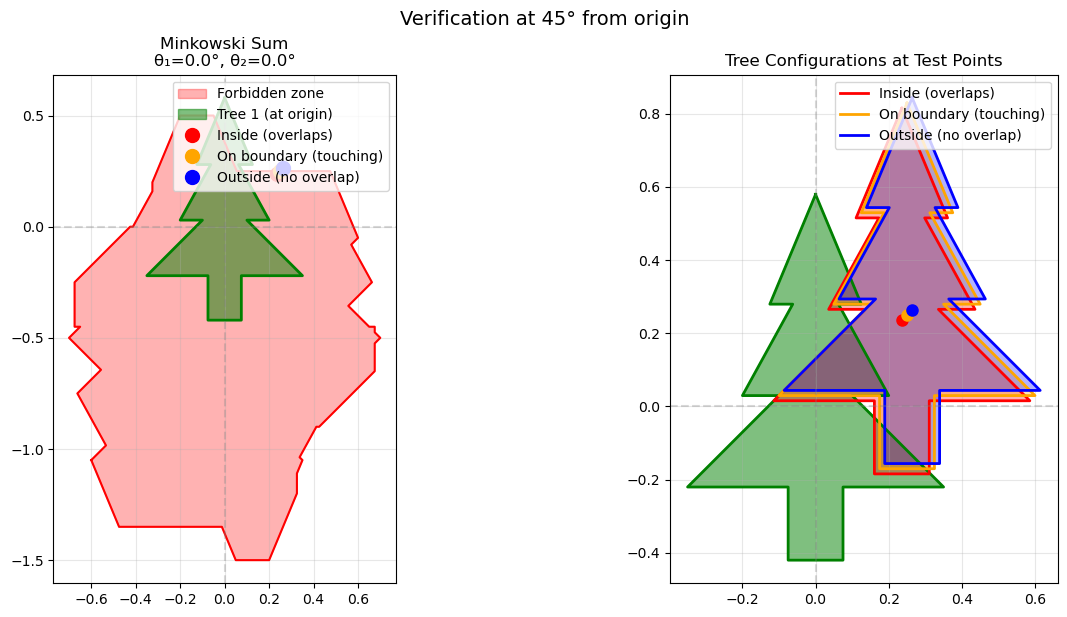


Actual overlap verification:
  Inside (overlaps): overlap area = 0.047621
  On boundary (touching): overlap area = 0.039769
  Outside (no overlap): overlap area = 0.031296


In [7]:
# Visualize specific test cases
test_angle = np.pi / 4  # 45 degrees

boundary_pt = find_boundary_point(msum, test_angle)
bx, by = boundary_pt
dist = np.sqrt(bx**2 + by**2)
ux, uy = bx/dist, by/dist

epsilon = 0.02  # Larger epsilon for visibility

test_points = [
    (bx - epsilon*ux, by - epsilon*uy, 'Inside (overlaps)', 'red'),
    (bx, by, 'On boundary (touching)', 'orange'),
    (bx + epsilon*ux, by + epsilon*uy, 'Outside (no overlap)', 'blue'),
]

fig = plot_minkowski_and_trees(msum, tree1, tree2, theta1, theta2, test_points)
plt.suptitle(f'Verification at {np.degrees(test_angle):.0f}° from origin', fontsize=14, y=1.02)
plt.show()

# Check actual overlaps
print("\nActual overlap verification:")
for px, py, label, color in test_points:
    tree2_at_pt = affinity.translate(tree2, xoff=px, yoff=py)
    overlap = tree1.intersection(tree2_at_pt)
    print(f"  {label}: overlap area = {overlap.area:.6f}")

## Test with Different Rotations

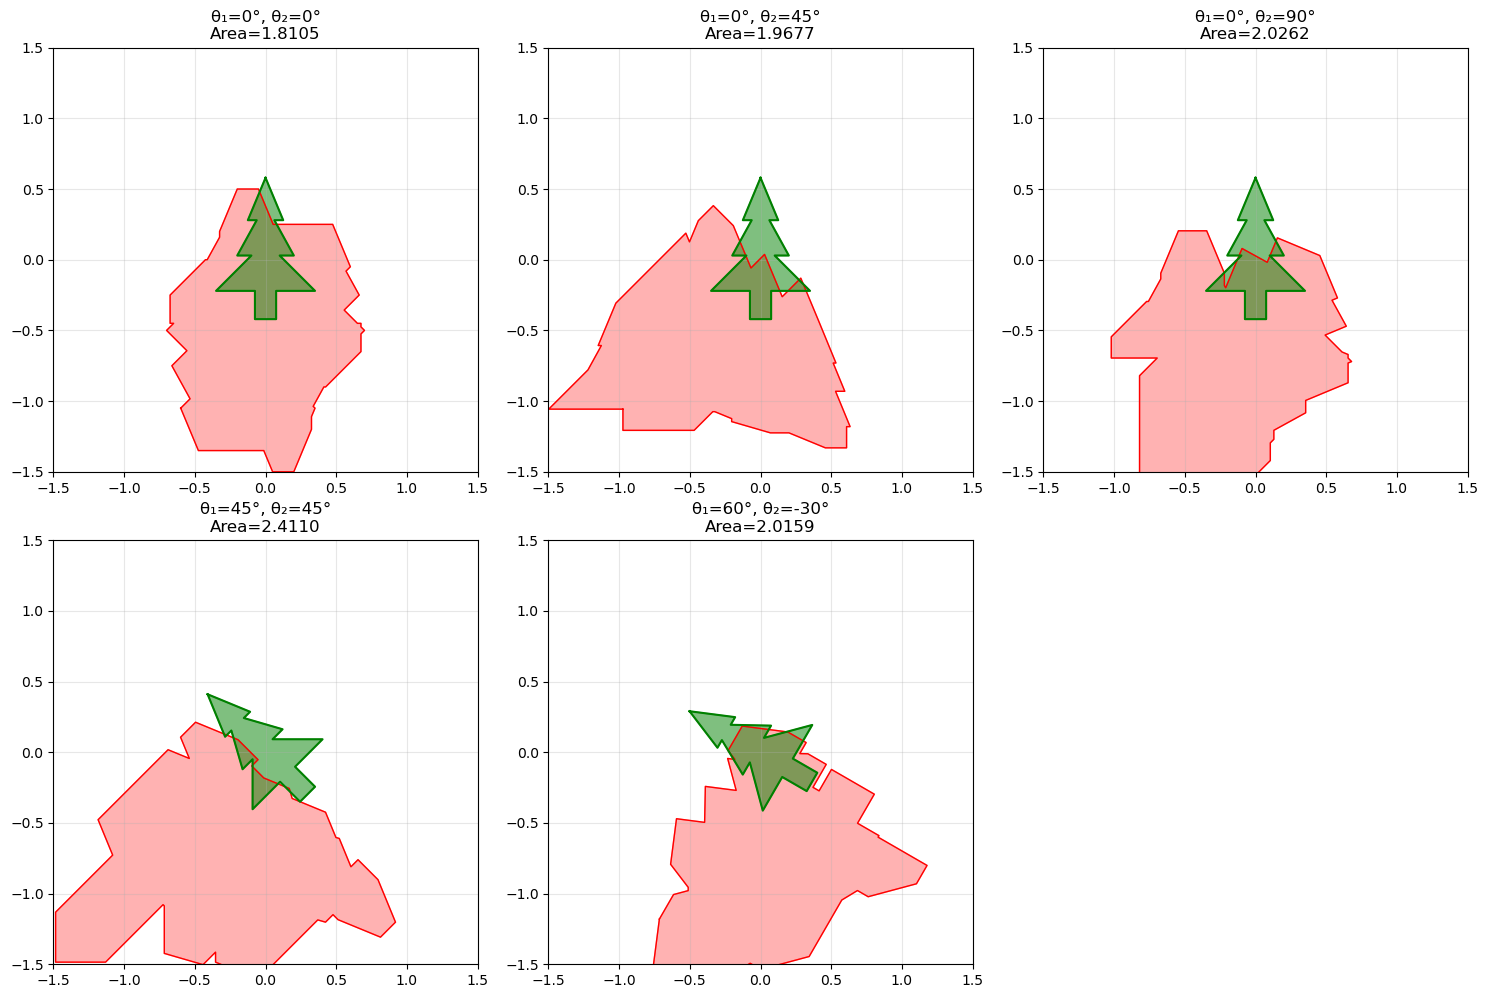

In [8]:
# Test with various rotation combinations
rotation_pairs = [
    (0.0, 0.0),
    (0.0, np.pi/4),
    (0.0, np.pi/2),
    (np.pi/4, np.pi/4),
    (np.pi/3, -np.pi/6),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (t1, t2) in enumerate(rotation_pairs):
    ax = axes[idx]
    msum, tree1, tree2 = compute_separation_minkowski(t1, t2)
    
    ax.set_aspect('equal')
    ax.set_title(f'θ₁={np.degrees(t1):.0f}°, θ₂={np.degrees(t2):.0f}°\nArea={msum.area:.4f}')
    
    # Plot Minkowski sum
    if isinstance(msum, MultiPolygon):
        for geom in msum.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red')
            ax.plot(x, y, 'r-', linewidth=1)
    else:
        x, y = msum.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red')
        ax.plot(x, y, 'r-', linewidth=1)
    
    # Plot tree at origin
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green')
    ax.plot(x, y, 'g-', linewidth=1.5)
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.grid(True, alpha=0.3)

# Hide last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## Separation Distance Function

The separation distance (penetration depth) is the minimum translation needed to separate overlapping trees.

In [9]:
def separation_distance(tree1_pos, tree2_pos, theta1, theta2):
    """
    Compute the exact separation distance between two trees.
    
    Parameters
    ----------
    tree1_pos : tuple (x, y)
        Position of tree 1
    tree2_pos : tuple (x, y)
        Position of tree 2
    theta1, theta2 : float
        Rotations of the trees
        
    Returns
    -------
    distance : float
        Separation distance. Positive if overlapping (penetration depth),
        negative if separated (clearance distance).
    """
    # Compute relative position (tree2 relative to tree1)
    dx = tree2_pos[0] - tree1_pos[0]
    dy = tree2_pos[1] - tree1_pos[1]
    
    # Get Minkowski sum for this rotation pair
    msum, _, _ = compute_separation_minkowski(theta1, theta2)
    
    # Check if relative position is inside Minkowski sum
    rel_point = Point(dx, dy)
    
    if msum.contains(rel_point):
        # Overlapping - find distance to boundary (penetration depth)
        dist_to_boundary = rel_point.distance(msum.exterior)
        return dist_to_boundary
    else:
        # Not overlapping - find distance to boundary (clearance)
        dist_to_boundary = rel_point.distance(msum.exterior)
        return -dist_to_boundary


# Test separation distance
test_cases = [
    ((0, 0), (0.5, 0), 0.0, 0.0),   # Close, overlapping
    ((0, 0), (1.0, 0), 0.0, 0.0),   # On boundary or just outside
    ((0, 0), (1.5, 0), 0.0, 0.0),   # Separated
    ((0, 0), (0.3, 0.3), 0.0, np.pi/4),  # Diagonal with rotation
]

print("Separation Distance Tests:")
print("-" * 70)
for t1_pos, t2_pos, t1, t2 in test_cases:
    sep_dist = separation_distance(t1_pos, t2_pos, t1, t2)
    status = "OVERLAPPING" if sep_dist > 0 else "SEPARATED"
    print(f"Tree1 at {t1_pos}, Tree2 at {t2_pos}, θ={np.degrees(t2):.0f}°: "
          f"sep_dist = {sep_dist:+.6f} ({status})")

Separation Distance Tests:
----------------------------------------------------------------------
Tree1 at (0, 0), Tree2 at (0.5, 0), θ=0°: sep_dist = +0.073090 (OVERLAPPING)
Tree1 at (0, 0), Tree2 at (1.0, 0), θ=0°: sep_dist = -0.403091 (SEPARATED)
Tree1 at (0, 0), Tree2 at (1.5, 0), θ=0°: sep_dist = -0.873984 (SEPARATED)
Tree1 at (0, 0), Tree2 at (0.3, 0.3), θ=45°: sep_dist = -0.377532 (SEPARATED)


## Interactive Visualization

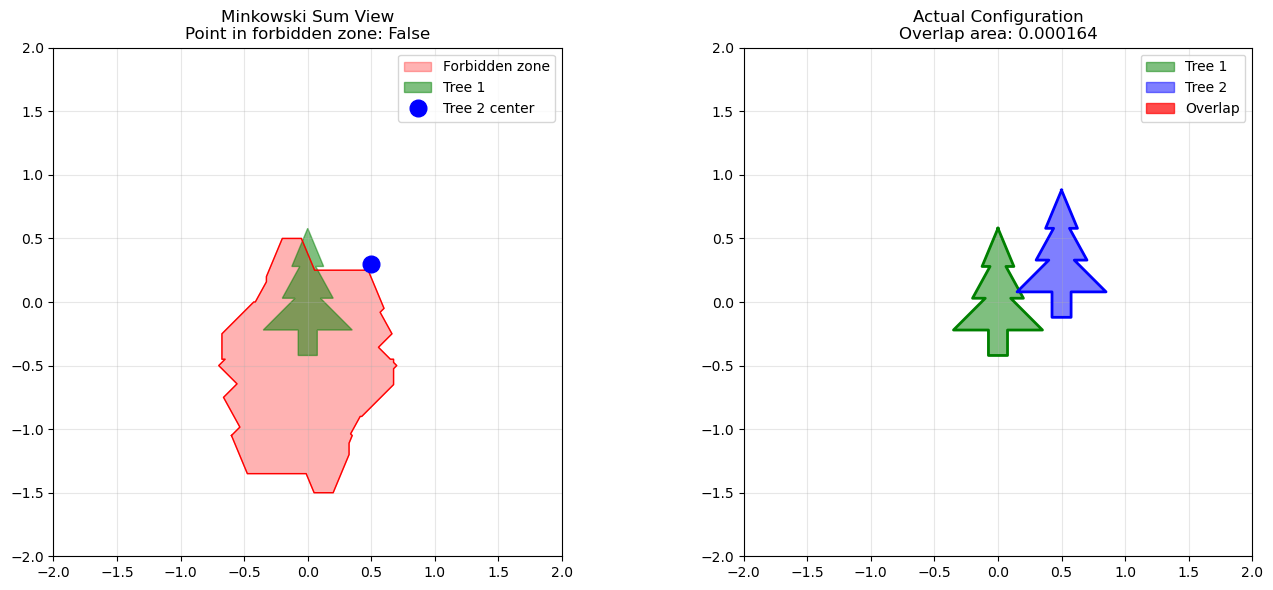

In Minkowski sum: False
Actually overlaps: True
Consistent: ✗ MISMATCH!


False

In [10]:
def interactive_test(theta1_deg, theta2_deg, dx, dy):
    """
    Interactive test: visualize tree configuration and verify against Minkowski sum.
    """
    theta1 = np.radians(theta1_deg)
    theta2 = np.radians(theta2_deg)
    
    msum, tree1, tree2 = compute_separation_minkowski(theta1, theta2)
    
    # Check overlap
    tree2_translated = affinity.translate(tree2, xoff=dx, yoff=dy)
    actual_overlap = tree1.intersection(tree2_translated)
    
    # Check if in Minkowski sum
    in_msum = msum.contains(Point(dx, dy))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Minkowski sum view
    ax = axes[0]
    ax.set_aspect('equal')
    
    if isinstance(msum, MultiPolygon):
        for geom in msum.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red')
            ax.plot(x, y, 'r-', linewidth=1)
    else:
        x, y = msum.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
        ax.plot(x, y, 'r-', linewidth=1)
    
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1')
    
    color = 'red' if in_msum else 'blue'
    ax.plot(dx, dy, 'o', markersize=12, color=color, label=f'Tree 2 center')
    
    ax.set_title(f'Minkowski Sum View\nPoint in forbidden zone: {in_msum}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    # Right: Actual tree configuration
    ax = axes[1]
    ax.set_aspect('equal')
    
    x, y = tree1.exterior.xy
    ax.fill(x, y, alpha=0.5, color='green', label='Tree 1')
    ax.plot(x, y, 'g-', linewidth=2)
    
    x, y = tree2_translated.exterior.xy
    ax.fill(x, y, alpha=0.5, color='blue', label='Tree 2')
    ax.plot(x, y, 'b-', linewidth=2)
    
    # Highlight overlap
    if not actual_overlap.is_empty and actual_overlap.area > 0:
        if isinstance(actual_overlap, MultiPolygon):
            for geom in actual_overlap.geoms:
                x, y = geom.exterior.xy
                ax.fill(x, y, alpha=0.7, color='red')
        elif hasattr(actual_overlap, 'exterior'):
            x, y = actual_overlap.exterior.xy
            ax.fill(x, y, alpha=0.7, color='red', label='Overlap')
    
    ax.set_title(f'Actual Configuration\nOverlap area: {actual_overlap.area:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
    plt.tight_layout()
    plt.show()
    
    # Verify consistency
    overlaps = actual_overlap.area > 1e-10
    consistent = in_msum == overlaps
    print(f"In Minkowski sum: {in_msum}")
    print(f"Actually overlaps: {overlaps}")
    print(f"Consistent: {'✓' if consistent else '✗ MISMATCH!'}")
    
    return consistent


# Test cases
interactive_test(0, 0, 0.5, 0.3)  # Should overlap

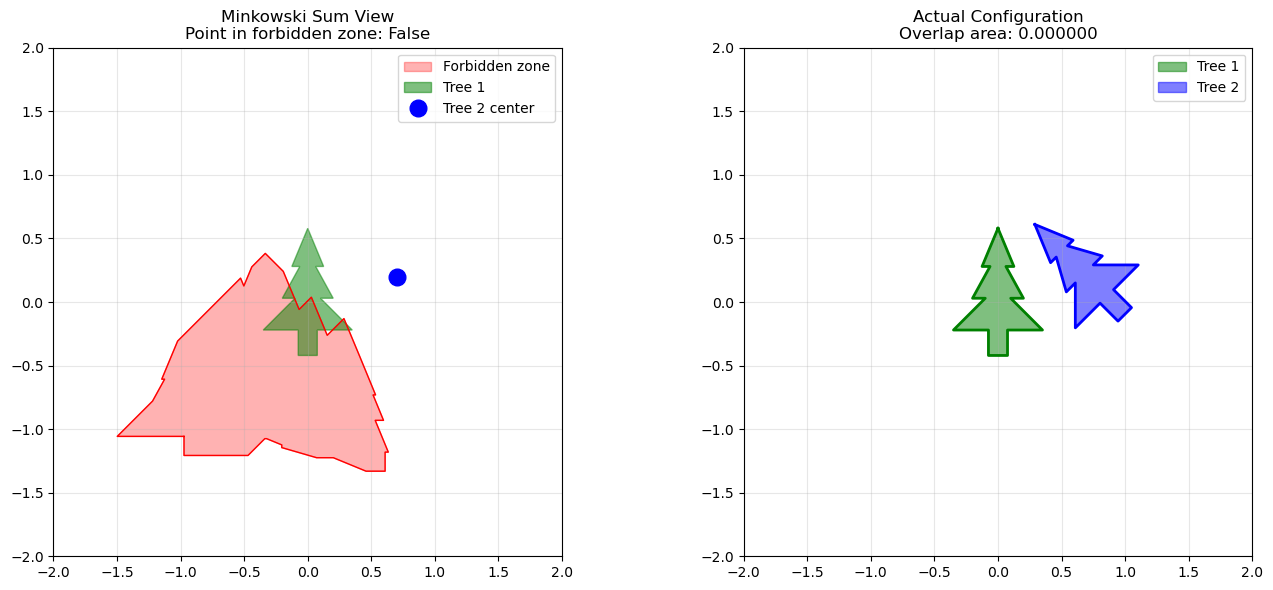

In Minkowski sum: False
Actually overlaps: False
Consistent: ✓


True

In [11]:
interactive_test(0, 45, 0.7, 0.2)  # With rotation

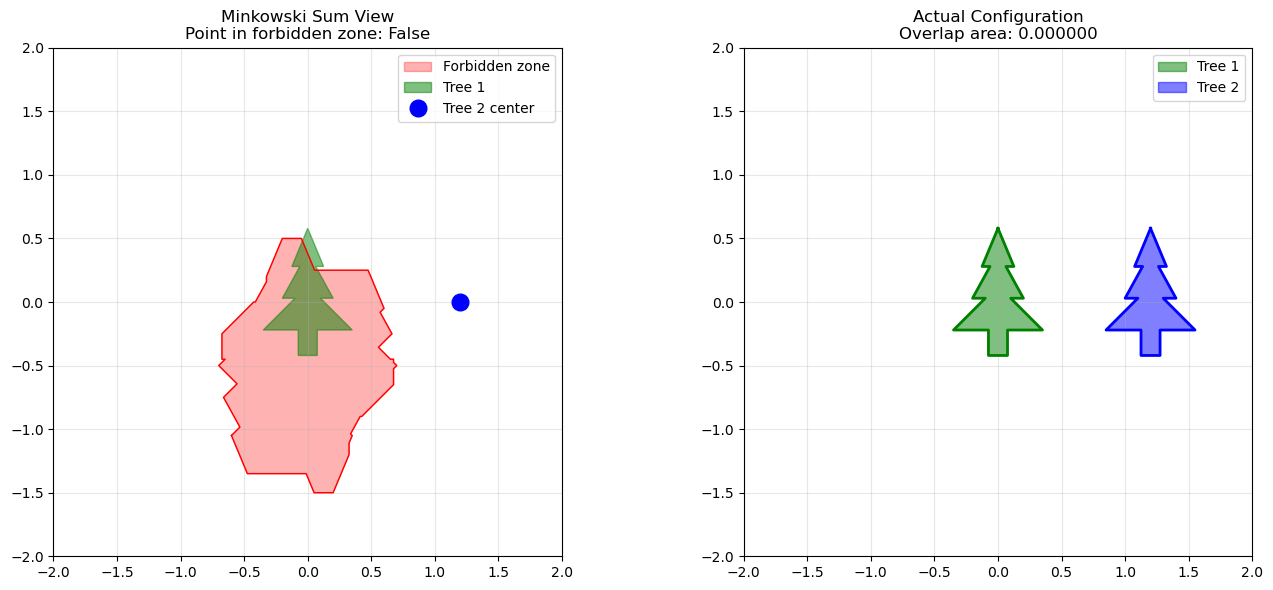

In Minkowski sum: False
Actually overlaps: False
Consistent: ✓


True

In [12]:
interactive_test(0, 0, 1.2, 0.0)  # Should not overlap

## Summary

The Minkowski sum approach provides **exact** separation distance computation:

1. **Minkowski Sum M(A, -B)** represents all positions where B's center would cause overlap with A
2. For non-convex polygons, we use **convex decomposition** and union of pairwise sums
3. **Separation distance** = signed distance from relative position to Minkowski boundary
   - Positive: penetration depth (trees overlap)
   - Negative: clearance (trees don't overlap)

This is suitable for building a lookup table since:
- The computation depends only on (θ₁, θ₂, dx, dy)
- Due to symmetry, we can reduce to (Δθ = θ₂ - θ₁, dx, dy)
- The Minkowski sum only needs to be computed once per Δθ value